In [42]:
# Requires 0.24
import os
import sys
sys.path.insert(1,os.path.abspath('../0. Not_git/Sources/scikit-learn/0.24.0'))
import sklearn
print(sklearn.__version__)
#this will be 0.24.2 

0.24.0


## Multivariate series forecasting

https://joaquinamatrodrigo.github.io/skforecast/0.6.0/user_guides/multivariate-forecasting.html

### Import libraries

In [43]:
# Modules
import numpy as np
import math
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

# Metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Autoregressor
from skforecast.ForecasterAutoregMultiVariate import ForecasterAutoregMultiVariate

# Hyperparameter Grid search
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries

# Backtesting
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries

# Models
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import StandardScaler

import plotly.io as pio

In [44]:
# Enable to render plotly graphs into GitHub
#pio.renderers.default = "svg"

In [45]:
country = 'ALL'
dep_var = 'FIN'

### Load Data

In [46]:
# Input path and filename
path = 'D:/Git_Projects/5. Master_thesis/Datasets/Output_files/'

# Load files into a pandas dataframes
file = path + 'Orders.xlsx'

df = pd.read_excel(file, sheet_name=country)

# Set index
df = df.set_index("Date").asfreq('MS')

In [47]:
df

,FIN,DEN,NOR,SWE
Date,,,,
2006-01-01,1124,161,233,110
2006-02-01,1079,250,270,303
2006-03-01,1210,468,406,634
2006-04-01,1147,412,356,1097
2006-05-01,1001,550,553,926
...,...,...,...,...
2022-08-01,254,343,347,744
2022-09-01,228,337,295,666
2022-10-01,188,322,413,711


### Split Data

In [48]:
# Split data
steps = 36  # Number of months of testing
train = df[:-steps]
test  = df[-steps:]

print(f"Dataset length : (n={len(df)})")
print(f"Train dates    : {train.index.min()} --- {train.index.max()}  (n={len(train)})")
print(f"Test dates     : {test.index.min()} --- {test.index.max()}  (n={len(test)})")

start = train.index.min()
end = df.index.max()
start_test = test.index.min()

start, end, start_test

print('\nData shape:', train.shape, test.shape)

Dataset length : (n=204)
Train dates    : 2006-01-01 00:00:00 --- 2019-12-01 00:00:00  (n=168)
Test dates     : 2020-01-01 00:00:00 --- 2022-12-01 00:00:00  (n=36)

Data shape: (168, 4) (36, 4)


### Scoring function

In [49]:
metrics = pd.DataFrame()

def scoring(model_name, y_true, y_pred, print_metrics: bool, plot_results: bool):

    # Calculate metrics
    mae = mean_absolute_error(y_true, y_pred)                      # MAE (Mean Absolute Error)
    mse = mean_squared_error(y_true, y_pred)                       # MSE (Mean Squared Error)
    rmse = math.sqrt(mse)                                          # RMSE (Root Mean Squared Error)
    r2 = r2_score(y_true, y_pred)                                  # R2 (R-squared - Coeficient of determination)                           
    mape = np.mean(np.abs((y_true - y_pred) /y_true)) * 100        # MAPE
    accuracy = 100 - mape                                          # Accuracy

    # Append metrics for summary
    metrics[model_name] = [mae, mse, rmse, r2, mape, accuracy]
    metrics.index = ['Mean Absolute Error', 
                    'Mean Squared Error', 
                    'Root Mean Squared Error',
                    'R^2',
                    'Mean Absolute Percentage Error',
                    'Accuracy']

    # Print metrics  
    if print_metrics:
 
        print(model_name, 'Model Performance:')                             # Model name
        print('Mean Absolute Error: {:0.2f}.'.format(mae))                  # MAE
        print('Mean Squared Error: {:0.2f}.'.format(mse))                   # MSE
        print('Root Mean Squared Error: {:0.2f}.'.format(rmse))             # RMSE  
        print('R^2 Score = {:0.2f}.'.format(r2))                            # R2
        print('Mean Absolute Percentage Error: {:0.2f}%.'.format(mape))     # MAPE 
        print('Accuracy = {:0.2f}%.'.format(accuracy))                      # Accuracy
        
    # Plot Actual values vs predicted values
    if plot_results:
        
        df = pd.DataFrame(y_true)

        fig= make_subplots(rows=2, cols=1)
        
        fig.add_trace(go.Scatter(dict(x=df.index, y=y_true, mode='lines', name= 'Actual'), legendgroup="Preds"), row=1, col=1)
        fig.add_trace(go.Scatter(dict(x=df.index, y=y_pred, mode='lines', name= 'Predicted'), legendgroup="Preds"), row=1, col=1)
        
        fig.add_trace(go.Scatter(dict(x=train.index, y=train[dep_var], mode='lines', name= 'Train'), legendgroup="Full"), row=2, col=1)
        fig.add_trace(go.Scatter(dict(x=test.index, y=y_true, mode='lines', name= 'Test'), legendgroup="Full"), row=2, col=1)
        fig.add_trace(go.Scatter(dict(x=test.index, y=y_pred, mode='lines', name= 'Forecast'), legendgroup="Full"), row=2, col=1)

        fig.update_layout(height=600, width=1000, title_text=model_name + " Predictions in " + country)    

        fig.show()  

### Models

In [54]:
# Dependant variable
dep_vars = ['FIN']#, 'DEN', 'NOR', 'SWE']

In [55]:

modelclasses = [
    ["Extra Tree", ExtraTreesRegressor],
    ["XGBoost", XGBRegressor],
    ["Gradient Boosting", GradientBoostingRegressor],
    ["Random Forest", RandomForestRegressor],
    ["Ada Boost", AdaBoostRegressor],
    ["LightGBM", LGBMRegressor],
    ["Decision Tree", DecisionTreeRegressor]
]

for dep_var in dep_vars:
    number_of_lags = 12

    for model_name, Model in modelclasses:            

        # Create forecaster
        forecaster = ForecasterAutoregMultiVariate(
                    regressor          = Model(),
                    level              = dep_var,
                    lags               = number_of_lags,
                    steps              = steps,
                    transformer_series = StandardScaler(),
                    transformer_exog   = None,
                    weight_func        = None
                )
    
        # Fit model
        forecaster.fit(series=train)
        
        # Predict
        preds = forecaster.predict(steps=steps)

        # Score
        scoring(model_name + '_' + dep_var, test[dep_var], preds[dep_var], True, True)

Extra Tree_FIN Model Performance:
Mean Absolute Error: 338.01.
Mean Squared Error: 125852.00.
Root Mean Squared Error: 354.76.
R^2 Score = -12.14.
Mean Absolute Percentage Error: 138.79%.
Accuracy = -38.79%.


XGBoost_FIN Model Performance:
Mean Absolute Error: 312.94.
Mean Squared Error: 115071.54.
Root Mean Squared Error: 339.22.
R^2 Score = -11.02.
Mean Absolute Percentage Error: 132.17%.
Accuracy = -32.17%.


Gradient Boosting_FIN Model Performance:
Mean Absolute Error: 320.62.
Mean Squared Error: 117755.47.
Root Mean Squared Error: 343.16.
R^2 Score = -11.30.
Mean Absolute Percentage Error: 133.16%.
Accuracy = -33.16%.


Random Forest_FIN Model Performance:
Mean Absolute Error: 328.42.
Mean Squared Error: 118545.58.
Root Mean Squared Error: 344.30.
R^2 Score = -11.38.
Mean Absolute Percentage Error: 135.38%.
Accuracy = -35.38%.


Ada Boost_FIN Model Performance:
Mean Absolute Error: 316.49.
Mean Squared Error: 111923.11.
Root Mean Squared Error: 334.55.
R^2 Score = -10.69.
Mean Absolute Percentage Error: 131.05%.
Accuracy = -31.05%.


LightGBM_FIN Model Performance:
Mean Absolute Error: 341.63.
Mean Squared Error: 131021.70.
Root Mean Squared Error: 361.97.
R^2 Score = -12.68.
Mean Absolute Percentage Error: 137.87%.
Accuracy = -37.87%.


Decision Tree_FIN Model Performance:
Mean Absolute Error: 318.44.
Mean Squared Error: 126719.50.
Root Mean Squared Error: 355.98.
R^2 Score = -12.24.
Mean Absolute Percentage Error: 131.58%.
Accuracy = -31.58%.


In [52]:
metrics

,Extra Tree_FIN,XGBoost_FIN,Gradient Boosting_FIN,Random Forest_FIN,Ada Boost_FIN,LightGBM_FIN,Decision Tree_FIN,Extra Tree_DEN,XGBoost_DEN,Gradient Boosting_DEN,...,Ada Boost_NOR,LightGBM_NOR,Decision Tree_NOR,Extra Tree_SWE,XGBoost_SWE,Gradient Boosting_SWE,Random Forest_SWE,Ada Boost_SWE,LightGBM_SWE,Decision Tree_SWE
Mean Absolute Error,342.115000,312.938054,318.886110,330.625000,320.217247,341.628281,319.666667,492.425278,484.506781,525.012192,...,300.569468,423.326461,357.583333,466.740556,465.090919,495.298016,448.166111,438.972269,507.439074,483.944444
Mean Squared Error,127851.471239,115071.535411,117133.907383,119615.880461,112893.524179,131021.701843,125411.333333,285196.704208,283837.836438,338604.557025,...,127234.118582,253388.698315,199082.194444,254149.735356,252413.676832,287286.506436,235938.223489,226400.981952,301974.804696,322327.500000
Root Mean Squared Error,357.563241,339.221956,342.248312,345.855288,335.996316,361.969200,354.134626,534.038111,532.764335,581.897377,...,356.698919,503.377292,446.186278,504.132657,502.407879,535.991144,485.734725,475.816122,549.522342,567.738936
R^2,-12.353268,-11.018485,-11.233887,-11.493113,-10.791006,-12.684378,-12.098411,-4.567415,-4.540888,-5.610007,...,-2.956056,-6.878546,-5.190009,-6.393676,-6.343171,-7.357685,-5.863870,-5.586415,-7.784994,-8.377091
Mean Absolute Percentage Error,139.592500,132.172545,132.851481,135.813485,131.235181,137.872640,132.282325,163.905160,161.693393,175.773382,...,101.455205,139.801505,109.845135,100.168378,97.940865,105.240780,96.487281,93.901213,107.538694,101.452659
Accuracy,-39.592500,-32.172545,-32.851481,-35.813485,-31.235181,-37.872640,-32.282325,-63.905160,-61.693393,-75.773382,...,-1.455205,-39.801505,-9.845135,-0.168378,2.059135,-5.240780,3.512719,6.098787,-7.538694,-1.452659


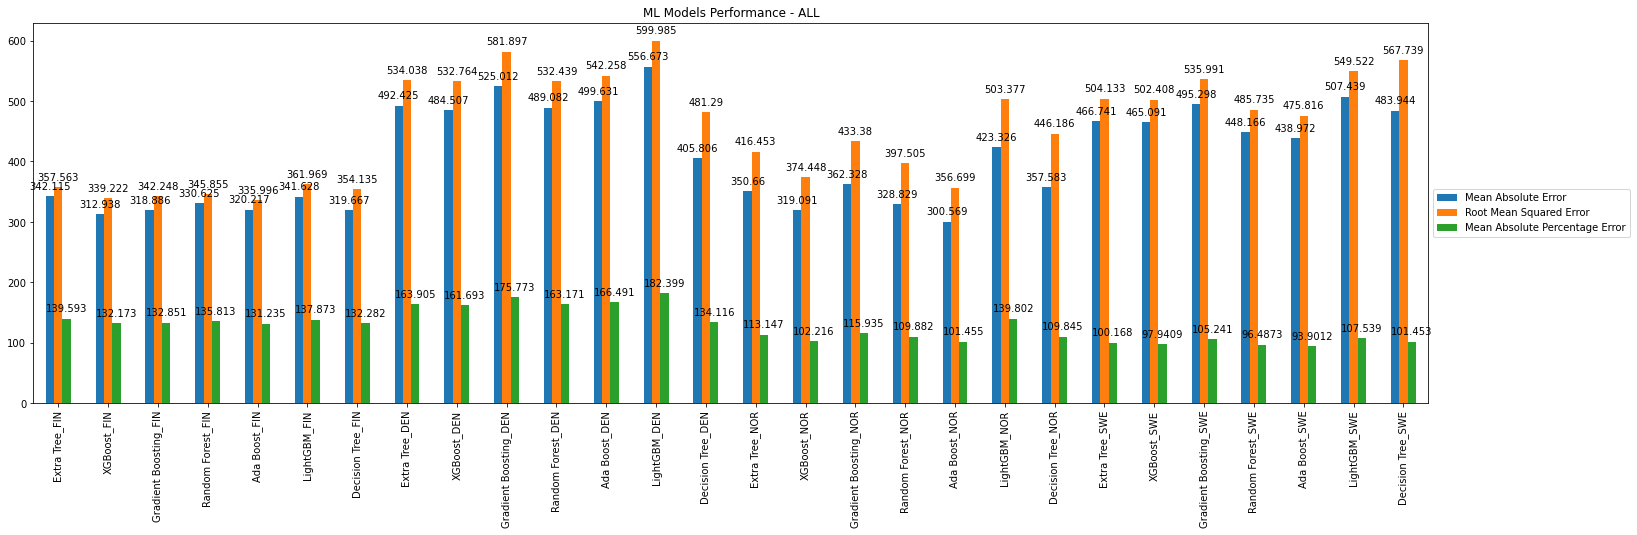

In [53]:
chart = metrics.transpose()
chart.drop(['Mean Squared Error', 'R^2', 'Accuracy'], axis=1, inplace=True)

ax = chart.plot.bar(title="ML Models Performance - " + country, figsize=(25,7))
for container in ax.containers:
    ax.bar_label(container, padding=5)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))